In [1]:
!pip install pyspark

In [2]:
import pyspark

In [3]:
import pandas as pd
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, BooleanType
from pyspark.sql.functions import col, max, min

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("title", StringType(), True),
    StructField("original_language", StringType(), True),
    StructField("release_date", StringType(), True),
    StructField("vote_average", FloatType(), True),
    StructField("popularity", FloatType(), True),
    StructField("adult", BooleanType(), True)
])

In [6]:
spark = SparkSession.builder.appName("Linear-regration-movies").getOrCreate()

23/07/25 12:27:37 WARN Utils: Your hostname, Apex-Standard-BC-C02FXKEGMD6M.local resolves to a loopback address: 127.0.0.1; using 192.168.1.69 instead (on interface en0)
23/07/25 12:27:37 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/07/25 12:27:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [7]:
spark

In [8]:
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=Linear-regration-movies>

In [10]:
movies_dataframe = spark.read.csv("Movies_data.csv", header=True, inferSchema=True)
movies_dataframe = movies_dataframe.drop('_c0')
movies_dataframe = movies_dataframe.dropDuplicates()
movies_dataframe = movies_dataframe.na.fill('Missing Values',['title','release_date'])

movies_dataframe = movies_dataframe.na.drop(how="all")
movies_dataframe.show()

+------+--------------------+-----------------+------------+------------+----------+-----+
|    id|               title|original_language|release_date|vote_average|popularity|adult|
+------+--------------------+-----------------+------------+------------+----------+-----+
|527774|Raya and the Last...|               en|  2021-03-03|         7.9|    82.854|False|
|597922|The Greatest Beer...|               en|  2022-09-30|         7.7|    23.908|False|
|   702|A Streetcar Named...|               en|  1951-09-18|         7.7|     16.62|False|
| 31216|I Can't Think Str...|               en|  2008-06-01|         7.6|    17.169|False|
| 21849| A Face in the Crowd|               en|  1957-05-29|         7.6|    10.043|False|
|491418|      Instant Family|               en|  2018-11-16|         7.5|    27.068|False|
|   530|     A Grand Day Out|               en|  1990-05-18|         7.5|    24.321|False|
|  1653|The Motorcycle Di...|               es|  2004-02-06|         7.4|    14.146|False|

In [11]:
movies_dataframe.printSchema()

root
 |-- id: string (nullable = true)
 |-- title: string (nullable = false)
 |-- original_language: string (nullable = true)
 |-- release_date: string (nullable = false)
 |-- vote_average: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- adult: string (nullable = true)



In [12]:
mov_df = movies_dataframe
mov_df.columns

['id',
 'title',
 'original_language',
 'release_date',
 'vote_average',
 'popularity',
 'adult']

In [13]:
mov_df.select('id', 'title').show(10)

+------+--------------------+
|    id|               title|
+------+--------------------+
|527774|Raya and the Last...|
|597922|The Greatest Beer...|
|   702|A Streetcar Named...|
| 31216|I Can't Think Str...|
| 21849| A Face in the Crowd|
|491418|      Instant Family|
|   530|     A Grand Day Out|
|  1653|The Motorcycle Di...|
|239877|The Mafia Kills O...|
| 61791|Rise of the Plane...|
+------+--------------------+
only showing top 10 rows



In [14]:
result_df = mov_df.groupBy('vote_average').count().sort('vote_average', ascending=False)

In [15]:
result_df.show(10)

+------------+-----+
|vote_average|count|
+------------+-----+
|         8.7|    2|
|         8.6|    4|
|         8.5|   19|
|         8.4|   33|
|         8.3|   47|
|         8.2|   75|
|         8.1|   81|
|         8.0|  126|
|         7.9|  171|
|         7.8|  196|
+------------+-----+
only showing top 10 rows



<Axes: xlabel='vote_average'>

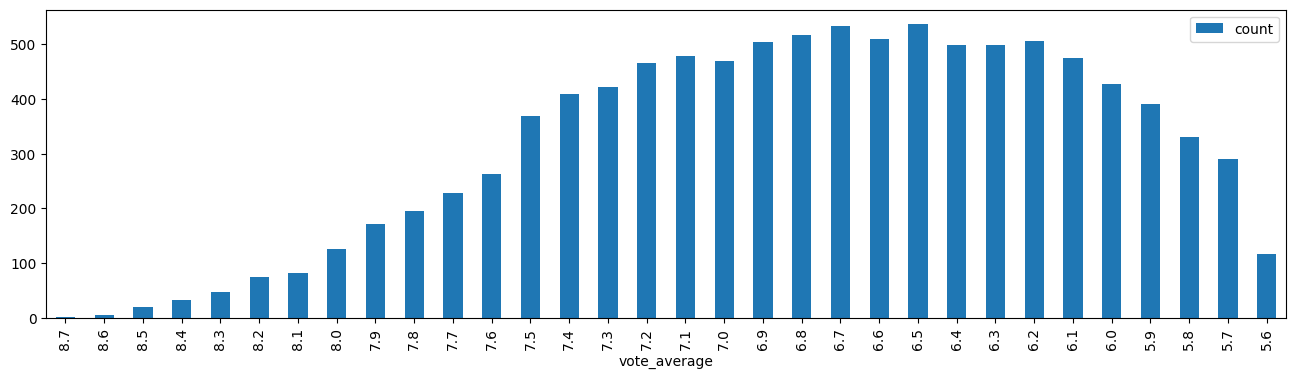

In [16]:
result_df.toPandas().plot.bar(x='vote_average', figsize=(16,4))

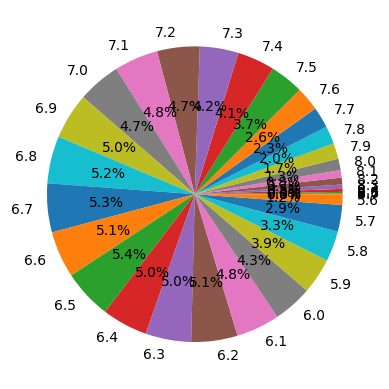

In [17]:
pandas_df = result_df.toPandas()
plt.pie(pandas_df['count'], labels=pandas_df['vote_average'], autopct='%1.1f%%')
plt.show()

In [18]:
common_vote = mov_df.groupBy('vote_average').count().orderBy(col("count").desc()).first()["vote_average"]
# if we remove desc() we will get the highest vote results
print(common_vote)
most_voted_df = mov_df.filter(col("vote_average") == common_vote)
most_voted_df.show()

6.5
+-------+--------------------+-----------------+------------+------------+----------+-----+
|     id|               title|original_language|release_date|vote_average|popularity|adult|
+-------+--------------------+-----------------+------------+------------+----------+-----+
| 172385|               Rio 2|               en|  2014-03-19|         6.5|    35.102|False|
| 331583|     The Whole Truth|               en|  2016-03-25|         6.5|    12.679|False|
|1013860|R.I.P.D. 2: Rise ...|               en|  2022-11-15|         6.5|   132.913|False|
|   9437|      Kiss the Girls|               en|  1997-09-29|         6.5|    16.839|False|
|  11681|The Two Missionaries|               it|  1974-12-21|         6.5|     7.807|False|
| 467482|    A Man in a Hurry|               fr|  2018-11-07|         6.5|     6.999|False|
|  10939|The Return of the...|               fr|  1974-11-12|         6.5|      8.58|False|
|    152|Star Trek: The Mo...|               en|  1979-12-07|         6.5|  

In [19]:
popu_movie = mov_df.select(max('popularity')).first()[0]
# We can use min to grave the least popular movies
print(popu_movie)
most_popu_df = mov_df.filter(col("popularity") == popu_movie)
most_popu_df.show()

99.842
+---+--------------+-----------------+------------+------------+----------+-----+
| id|         title|original_language|release_date|vote_average|popularity|adult|
+---+--------------+-----------------+------------+------------+----------+-----+
|585|Monsters, Inc.|               en|  2001-11-01|         7.8|    99.842|False|
+---+--------------+-----------------+------------+------------+----------+-----+



In [39]:
# Convertir una columna de String a Float
mov_df = mov_df.withColumn("vote_average", col("vote_average").cast("float"))
mov_df = mov_df.withColumn("popularity", col("popularity").cast("float"))
#buscar peliculas con votos arriba de 8.0 despues ordenarlos por votos y despues por popularidad
mov_df.filter(mov_df['vote_average'] > 8.0).orderBy(col('vote_average').desc(), col('popularity').desc()).show()

+------+--------------------+-----------------+------------+------------+----------+-----+
|    id|               title|original_language|release_date|vote_average|popularity|adult|
+------+--------------------+-----------------+------------+------------+----------+-----+
|   238|       The Godfather|               en|  1972-03-14|         8.7|   114.574|False|
|   278|The Shawshank Red...|               en|  1994-09-23|         8.7|    91.998|False|
|569094|Spider-Man: Acros...|               en|  2023-05-31|         8.6|  1586.317|False|
|   240|The Godfather Par...|               en|  1974-12-20|         8.6|     61.49|False|
|   424|    Schindler's List|               en|  1993-12-15|         8.6|    43.764|False|
| 19404|Dilwale Dulhania ...|               hi|  1995-10-20|         8.6|    28.989|False|
|   155|     The Dark Knight|               en|  2008-07-14|         8.5|    92.305|False|
|372058|          Your Name.|               ja|  2016-08-26|         8.5|    83.288|False|

In [29]:
mov_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- title: string (nullable = false)
 |-- original_language: string (nullable = true)
 |-- release_date: string (nullable = false)
 |-- vote_average: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- adult: string (nullable = true)



In [30]:
schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("title", StringType(), True),
    StructField("original_language", StringType(), True),
    StructField("release_date", StringType(), True),
    StructField("vote_average", FloatType(), True),
    StructField("popularity", FloatType(), True),
    StructField("adult", BooleanType(), True)
])

In [31]:
mov_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- title: string (nullable = false)
 |-- original_language: string (nullable = true)
 |-- release_date: string (nullable = false)
 |-- vote_average: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- adult: string (nullable = true)

